# Exploratory notebook 2 After preliminary _qc.

Here we make a subject wise df and start cleaning using the process developed in the preliminary qc notebook. We want to start looking at RT and thinking about what kind of things will warrant subject exclusion is what we look go get out of this. 


First is loading:

In [39]:
import pandas as pd
# update to the file name to be read
# the header is the row that has the collumn names (zero indexed, and verify which is the header row before running)
# the sep is the seperator of the data
df = pd.read_csv("anagram_rating_pilot_filtered_20240808_1713.csv", header=0, sep=',')
# reading in the df from the prelim qc file
statsdf = pd.read_csv("anagram_statistics20240819_1557.csv", header=0, sep=',')

## Filter out the good trials, each trial each subject is it valid and then group by 

    1. dataframe of only anagram trials (delete the rows that aren't trials)
    2. new collumn, for each response is it valid row by row

Should be in a structure now that can be grouped by subject or by anagram

In [40]:
# similar to the qc but we will change direction 
long_df = df.filter(['workerid', 'id', 'anagram', 'response', 'rt', 'setRun']).dropna()
long_df = long_df[~((long_df['id'] == 'practice') | (long_df['id']== 'end_confirm_subjid'))]
long_df['id'] = long_df['id'].apply(lambda x: int(x))

# use the stat_df to get the correct answers using the id to match with the correct anagram, this will mean doing a lamda such that for each id in long df we get the correct
# anagram from the statsdf
long_df['correct'] = long_df.apply(lambda x: statsdf[statsdf['id'] == x['id']]['correct'].values[0], axis=1)

# Use the qc process for checking validity 
We're making a collumn that will have a boolean to check that the answer is /isn't valid. 

In [41]:
valid_responses = pd.read_csv("qc_responses.csv", header=0, sep=',') 
# function to get unique strings from each row
def get_unique_strings(row):
    # Filter out NaN values
    filtered = [item for item in row if pd.notna(item)]
    # Return the unique values in the list
    return list(set(filtered))
answers = valid_responses.apply(get_unique_strings, axis=1)
all_unique_answers = set(item for sublist in answers for item in sublist)
# make sure the whole response column is in lower case
long_df['response'] = long_df['response'].str.lower()
# make a column in the long_df to check from inside the answers if the response is valid
long_df['valid'] = long_df['response'].isin(all_unique_answers)

## Groups 
Now that there's a validity col in the long _df we can make groups to look at the data 

- measure of central tendancy 
- transform on the RT sq rt transform
- 

/var/folders/4n/6xdj3h3x4v94vpyhm5330k280000gn/T/ipykernel_53380/3026346906.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['rt'] = valid_df['rt'] / 1000


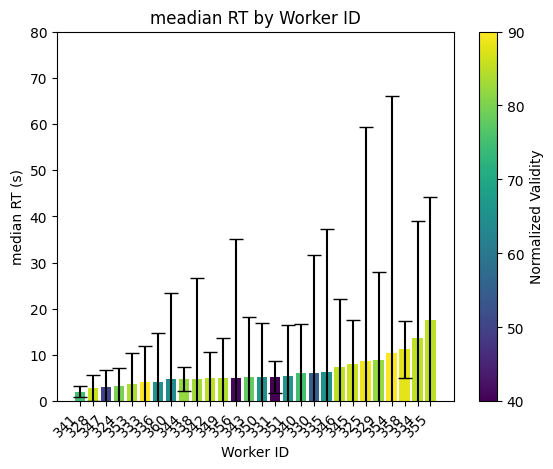

In [48]:
# group by the worker id and get the see the number of valid responses
worker_group = long_df.groupby('workerid')['valid'].sum()
worker_group = worker_group.reset_index()
# make worker_group index 
worker_index = worker_group.columns.get_loc('workerid')

# filtered DF of valid responses 
valid_df = long_df[long_df['valid'] == True]
# adjust the time in the rt to be seconds
valid_df['rt'] = valid_df['rt'] / 1000
# use that df for the rt mean
worker_group['rt_mean'] = valid_df.groupby('workerid')['rt'].mean().values
# use that df for the rt std
worker_group['rt_std'] = valid_df.groupby('workerid')['rt'].std().values
# use that df for the rt median
worker_group['rt_median'] = valid_df.groupby('workerid')['rt'].median().values

# okay cool lets a bar of that worker_group
import matplotlib.pyplot as plt
import numpy as np

# make the workerid a string so it doesn't try and sort out
worker_group['workerid'] = worker_group['workerid'].astype(str)
# Normalize the 'valid' column to range [0, 1]
norm = plt.Normalize(worker_group['valid'].min(), worker_group['valid'].max())

# Create a color map using valid collumn
colors = plt.cm.viridis(norm(worker_group['valid']))
# Sort 
worker_group = worker_group.sort_values(by='rt_median')

# Plot the bar chart
fig, ax = plt.subplots()
bars = ax.bar(worker_group['workerid'], worker_group['rt_median'], yerr=worker_group['rt_std'], capsize=5, color=colors)

# Add labels and title
ax.set_title('meadian RT by Worker ID')
ax.set_ylabel('median RT (s)')
ax.set_xlabel('Worker ID')
ax.set_ylim(0, 80)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add a color bar for the valid color 
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Validity')

plt.show()

## Group by Grams

Similar to the RT graph but now it's the anagrams rather than subjects
Droping things out bc they're long will bias responses.
For invalid response, the max rt for that anagram .


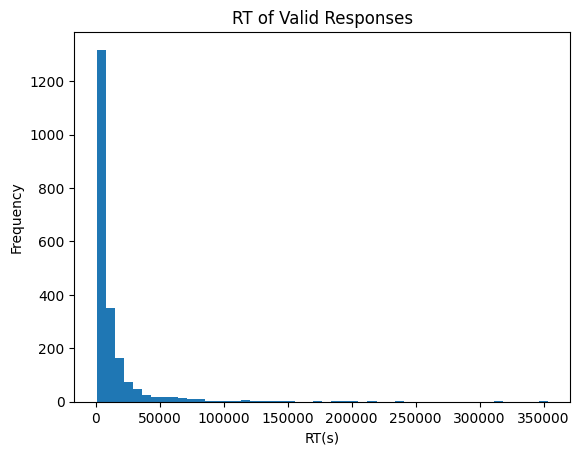

In [43]:
# plot the rt of the valid responses, mean for each anagram, the whole data set. Outlier test. 
plt.hist(valid_df['rt'], bins=50)
plt.title('RT of Valid Responses')
plt.xlabel('RT(s)')
plt.ylabel('Frequency')
plt.show()


Always recomment the save file before a git push.

In [44]:
# from datetime import datetime
# now = datetime.now()
# dt_string = now.strftime("%Y%m%d_%H%M")
# timestamped = 'subject_stats' + dt_string + '.csv'
# df.to_csv(timestamped, index=False)
# subject_stats.drop(['response'], axis=1).to_csv(timestamped, index=False)